# Project 3
## Task 3: Deep Anomaly Detection and Data Representation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans, DBSCAN
from sklearn.svm import OneClassSVM

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.metrics import silhouette_score, silhouette_samples, pairwise_distances_argmin_min, precision_recall_fscore_support, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.compose import ColumnTransformer
from pathlib import Path

from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torch

import torch
import random


## Helper functions

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"The device is set to: {device}")

The device is set to: cpu


In [3]:
# Seed al the libraries to ensure reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # for multi-GPU setups

# Example: setting a seed for reproducibility
set_seed(42)

In [4]:
def print_combined_classification_reports(y_true_train, y_pred_train,
                                         y_true_val, y_pred_val,
                                         y_true_test, y_pred_test):
    """
    Print classification reports for train, validation, and test sets in a compact format.

    Args:
        y_true_train, y_pred_train: True and predicted labels for training set
        y_true_val, y_pred_val: True and predicted labels for validation set
        y_true_test, y_pred_test: True and predicted labels for test set
        class_names: List of class names
    """

    # Calculate metrics for each set
    train_prec, train_rec, train_f1, train_support = precision_recall_fscore_support(y_true_train, y_pred_train, average=None, zero_division=0)
    val_prec, val_rec, val_f1, val_support = precision_recall_fscore_support(y_true_val, y_pred_val, average=None, zero_division=0)
    test_prec, test_rec, test_f1, test_support = precision_recall_fscore_support(y_true_test, y_pred_test, average=None, zero_division=0)

    train_acc = accuracy_score(y_true_train, y_pred_train)
    val_acc = accuracy_score(y_true_val, y_pred_val)
    test_acc = accuracy_score(y_true_test, y_pred_test)

    # Print compact report
    print("\n" + "="*125)
    print("CLASSIFICATION REPORT: Train / Validation / Test")
    print("="*125)
    print(f"{'Class':<20} {'Precision':<25} {'Recall':<25} {'F1-Score':<25} {'Support':<25}")
    print(f"{'':20} {'Train Val  Test':<25} {'Train Val  Test':<25} {'Train Val  Test':<25} {'Train  Val   Test':<25}")
    print("-"*125)

    for idx in range(2):
        print(f"{idx:<20}"
              f"{train_prec[idx]:>5.2f} {val_prec[idx]:>5.2f} {test_prec[idx]:>5.2f}\t      "
              f"{train_rec[idx]:>5.2f} {val_rec[idx]:>5.2f} {test_rec[idx]:>5.2f}\t\t"
              f"{train_f1[idx]:>5.2f} {val_f1[idx]:>5.2f} {test_f1[idx]:>5.2f}\t   "
              f"{train_support[idx]:>5} {val_support[idx]:>5} {test_support[idx]:>5}")

    print("-"*125)
    print(f"{'Accuracy':<20}{train_acc:>5.2f} {val_acc:>5.2f} {test_acc:>5.2f}")
    print("="*125)


In [5]:
def plot_confusion_matrices_combined(y_true_list, y_pred_list, class_names, titles, save_name=None):
    """
    Creates a combined figure with multiple confusion matrices in one row.

    Args:
        y_true_list: List of true labels arrays [train, val, test]
        y_pred_list: List of predicted labels arrays [train, val, test]
        class_names: List of class names for axis labels
        titles: List of titles for each subplot
        save_name: Optional filename for the consolidated confusion matrices.
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for idx, (y_true, y_pred, title, ax) in enumerate(zip(y_true_list, y_pred_list, titles, axes)):
        cm = confusion_matrix(y_true, y_pred)

        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                   xticklabels=class_names, yticklabels=class_names,
                   ax=ax, cbar_kws={'label': 'Count'}, annot_kws={'size': 11})

        ax.set_xlabel("Predicted Label", fontsize=12, fontweight='bold')
        ax.set_ylabel("True Label", fontsize=12, fontweight='bold')
        ax.set_title(title, fontsize=14, fontweight='bold', pad=15)

    plt.tight_layout()
    plt.show()

### Load the datasets

In [6]:
df_train = pd.read_csv('../data/preprocessed/train_preprocessed.csv')
df_val = pd.read_csv('../data/preprocessed/val_preprocessed.csv')
df_test = pd.read_csv('../data/preprocessed/test_preprocessed.csv')

In [7]:
df_train_normal_only = df_train[df_train["binary_label"]==0].copy()
X_train_normal_only = df_train_normal_only.drop(columns=['label', 'binary_label'])
y_train_normal_only = list(df_train_normal_only['binary_label'])

X_train = df_train.drop(columns=['label', 'binary_label'])
y_original_train = list(df_train['label'])
y_train = list(df_train['binary_label'])

X_val = df_val.drop(columns=['label', 'binary_label'])
y_original_val = list(df_val['label'])
y_val = list(df_val['binary_label'])

X_test = df_test.drop(columns=['label', 'binary_label'])
y_original_test = list(df_test['label'])
y_test = list(df_test['binary_label'])

### Training and Validating Autoencoder with Normal data only

In [8]:
class ImprovedAutoencoder(nn.Module):
    def __init__(self, input_dim, bottleneck_dim=16):
        super(ImprovedAutoencoder, self).__init__()

        # Encoder: deeper network, batchnorm, dropout
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, bottleneck_dim)
        )

        # Decoder: symmetric structure
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)     # bottleneck representation
        x_hat = self.decoder(z) # reconstruction
        return x_hat

    def encode(self, x):
        return self.encoder(x)  # return bottleneck representation


In [9]:
X_train_normal_tensor = torch.tensor(X_train_normal_only.values, dtype=torch.float32)
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

y_train_normal_tensor = torch.tensor(y_train_normal_only, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create dataset and dataloader
train_normal_dataset = TensorDataset(X_train_normal_tensor)
train_normal_dataloader = DataLoader(train_normal_dataset, batch_size=64, shuffle=True, worker_init_fn=lambda _: np.random.seed(42))
train_dataset = TensorDataset(X_train_tensor)
# Are we sure whether to shuffle here?
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, worker_init_fn=lambda _: np.random.seed(42))
val_dataset = TensorDataset(X_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataset = TensorDataset(X_test_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [10]:
def mixed_autoencoder_loss(x, x_recon, categorical_dims, numerical_idx):
    """
    Needed because we have numerical + categorical features!

    Args:
        x: original input [batch_size, num_features]
        x_recon: reconstructed input [batch_size, num_features]
        categorical_dims: list of (start_idx, end_idx) tuples for one-hot encoded categorical features
        numerical_idx: list of indices for numerical features

    Returns:
        Scalar loss value (MSE + sum of CE)
    """
    # Numerical loss (MSE)
    x_num = x[:, numerical_idx]
    x_recon_num = x_recon[:, numerical_idx]
    mse = F.mse_loss(x_recon_num, x_num)

    # Categorical loss (CE for each one-hot feature)
    ce = 0
    for start, end in categorical_dims:
        x_cat = x[:, start:end]
        x_recon_cat = x_recon[:, start:end]

        # CE expects class indices as targets
        target = torch.argmax(x_cat, dim=1)
        ce += F.cross_entropy(x_recon_cat, target)

    return mse + ce


def compute_per_sample_reconstruction_error(x, x_recon, categorical_dims, numerical_idx):
    """
    Returns a vector [batch_size] with the total reconstruction error (MSE + sum CE) for each sample
    """
    batch_size = x.shape[0]

    # Numerical error per sample
    x_num = x[:, numerical_idx]
    x_recon_num = x_recon[:, numerical_idx]
    mse_per_sample = torch.mean((x_num - x_recon_num) ** 2, dim=1)

    # Categorical CE error per sample (sum across categorical features)
    ce_total = torch.zeros(batch_size, device=x.device)
    for start, end in categorical_dims:
        x_cat = x[:, start:end]
        x_recon_cat = x_recon[:, start:end]

        target = torch.argmax(x_cat, dim=1)
        ce = F.cross_entropy(x_recon_cat, target, reduction='none')  # shape: [batch_size]
        ce_total += ce

    # Total reconstruction error per sample
    return mse_per_sample + ce_total


In [11]:
#Indexes to compute the loss function based on MSE and CE for categorical features
# Step 1: Get all column names
all_columns = [col for col in df_train_normal_only.columns if col not in ['label', 'binary_label']]

# Step 2: Get categorical index ranges
categorical_cols = ['protocol_type', 'service', 'flag']
categorical_dims = []
for col in categorical_cols:
    # Get all one-hot columns for this categorical feature
    one_hot_cols = [c for c in all_columns if c.startswith(col + "_")]
    if one_hot_cols:
        start_idx = all_columns.index(one_hot_cols[0])
        end_idx = start_idx + len(one_hot_cols)
        categorical_dims.append((start_idx, end_idx))

# Step 3: Get numerical column indexes
numerical_idx = [i for i, col in enumerate(all_columns)
                 if not any(col.startswith(c + "_") for c in categorical_cols)]

In [41]:
# Initialize model
input_dim = X_train.shape[1]
model = ImprovedAutoencoder(input_dim=input_dim, bottleneck_dim=8)

#Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)
#For the loss we use a custom implemenatation having categorical and numerical features
#mixed_autoencoder_loss

# Training loop
n_epochs = 100
model.train()
train_losses = []
for epoch in range(n_epochs):
    train_loss = 0
    for batch in train_normal_dataloader:
        x_batch = batch[0]
        optimizer.zero_grad()
        x_hat = model(x_batch)
        loss = mixed_autoencoder_loss(x_batch, x_hat, categorical_dims, numerical_idx)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(X_train_normal_tensor)
    train_losses.append(train_loss)  # Store training loss

    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {train_loss:.4f}")

Epoch 1/100, Loss: 0.0736
Epoch 2/100, Loss: 0.0385
Epoch 3/100, Loss: 0.0264
Epoch 4/100, Loss: 0.0214
Epoch 5/100, Loss: 0.0187
Epoch 6/100, Loss: 0.0172
Epoch 7/100, Loss: 0.0161
Epoch 8/100, Loss: 0.0149
Epoch 9/100, Loss: 0.0144
Epoch 10/100, Loss: 0.0136
Epoch 11/100, Loss: 0.0132
Epoch 12/100, Loss: 0.0129
Epoch 13/100, Loss: 0.0122
Epoch 14/100, Loss: 0.0119
Epoch 15/100, Loss: 0.0115
Epoch 16/100, Loss: 0.0113
Epoch 17/100, Loss: 0.0110
Epoch 18/100, Loss: 0.0107
Epoch 19/100, Loss: 0.0105
Epoch 20/100, Loss: 0.0101
Epoch 21/100, Loss: 0.0098
Epoch 22/100, Loss: 0.0097
Epoch 23/100, Loss: 0.0095
Epoch 24/100, Loss: 0.0094
Epoch 25/100, Loss: 0.0092
Epoch 26/100, Loss: 0.0090
Epoch 27/100, Loss: 0.0089
Epoch 28/100, Loss: 0.0088
Epoch 29/100, Loss: 0.0086
Epoch 30/100, Loss: 0.0085
Epoch 31/100, Loss: 0.0084
Epoch 32/100, Loss: 0.0084
Epoch 33/100, Loss: 0.0084
Epoch 34/100, Loss: 0.0081
Epoch 35/100, Loss: 0.0081
Epoch 36/100, Loss: 0.0081
Epoch 37/100, Loss: 0.0079
Epoch 38/1

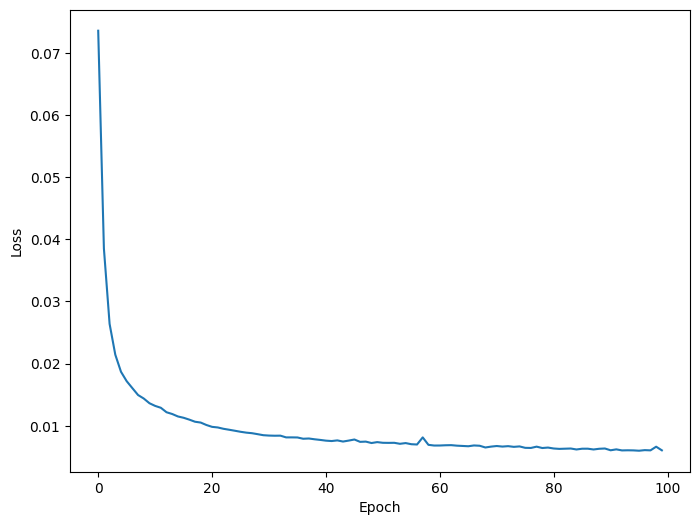

In [42]:
plt.figure(figsize=(8, 6))
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
plt.close()

# It seems it's converging

In [53]:
# TRAINING DATASET WITH ONLY NORMAL SAMPLES
# Switch to evaluation mode
model.eval()

# Reconstruct the full dataset
with torch.no_grad():
    X_train_normal_tensor = X_train_normal_tensor.to(next(model.parameters()).device)  # ensure correct device
    X_train_normal_reconstructed = model(X_train_normal_tensor)
    reconstruction_error_train_normal = compute_per_sample_reconstruction_error(
        X_train_normal_tensor, X_train_normal_reconstructed,
        categorical_dims=categorical_dims,
        numerical_idx=numerical_idx)

# Convert to NumPy
reconstruction_error_train_normal = reconstruction_error_train_normal.cpu().numpy()


# Use a threshold or percentile to detect anomalies
threshold = np.percentile(reconstruction_error_train_normal, 100-int(0.3*100))
predicted_anomalies_train_normal = (reconstruction_error_train_normal > threshold).astype(int)



Classification Report (Autoencoder vs Ground Truth):
              precision    recall  f1-score   support

           0       1.00      0.70      0.82     12102
           1       0.00      0.00      0.00         0

    accuracy                           0.70     12102
   macro avg       0.50      0.35      0.41     12102
weighted avg       1.00      0.70      0.82     12102



/Users/chiara/.venvs/ml4n/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/chiara/.venvs/ml4n/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/chiara/.venvs/ml4n/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


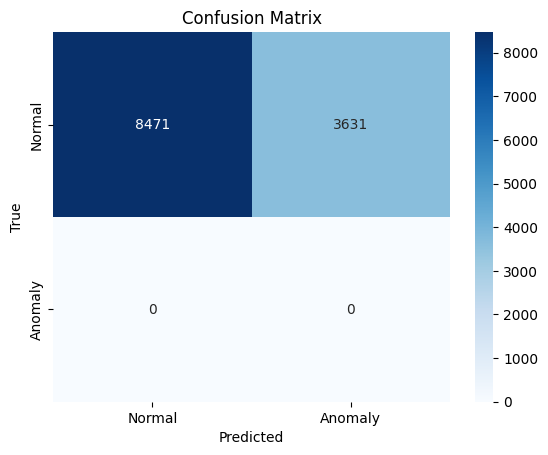

In [54]:
print("\nClassification Report (Autoencoder vs Ground Truth):")
print(classification_report(y_train_normal_tensor, predicted_anomalies_train_normal))
# Confusion matrix
cm = confusion_matrix(y_train_normal_tensor, predicted_anomalies_train_normal)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal','Anomaly'], yticklabels=['Normal','Anomaly'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
plt.close()

In [55]:
# TRAINING SET
# Reconstruct the full dataset
with torch.no_grad():
    X_train_tensor = X_train_tensor.to(next(model.parameters()).device)  # ensure correct device
    X_train_reconstructed = model(X_train_tensor)
    reconstruction_error_train = compute_per_sample_reconstruction_error(
        X_train_tensor, X_train_reconstructed,
        categorical_dims=categorical_dims,
        numerical_idx=numerical_idx)

# Convert to NumPy
reconstruction_error_train = reconstruction_error_train.cpu().numpy()

# Use a threshold or percentile to detect anomalies
threshold = np.percentile(reconstruction_error_train, 100-int(0.3*100))
predicted_anomalies_train = (reconstruction_error_train > threshold).astype(int)

# VAL SET
# Reconstruct the full dataset
with torch.no_grad():
    X_val_tensor = X_val_tensor.to(next(model.parameters()).device)  # ensure correct device
    X_val_reconstructed = model(X_val_tensor)
    reconstruction_error_val = compute_per_sample_reconstruction_error(
        X_val_tensor, X_val_reconstructed,
        categorical_dims=categorical_dims,
        numerical_idx=numerical_idx)

# Convert to NumPy
reconstruction_error_val = reconstruction_error_val.cpu().numpy()

# Use a threshold or percentile to detect anomalies
threshold = np.percentile(reconstruction_error_val, 100-int(0.3*100))
predicted_anomalies_val = (reconstruction_error_val > threshold).astype(int)

# TEST SET
# Reconstruct the full dataset
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(next(model.parameters()).device)  # ensure correct device
    X_test_reconstructed = model(X_test_tensor)
    reconstruction_error_test = compute_per_sample_reconstruction_error(
        X_test_tensor, X_test_reconstructed,
        categorical_dims=categorical_dims,
        numerical_idx=numerical_idx)

# Convert to NumPy
reconstruction_error_test = reconstruction_error_test.cpu().numpy()

# Use a threshold or percentile to detect anomalies
threshold = np.percentile(reconstruction_error_test, 100-int(0.3*100))
predicted_anomalies_test = (reconstruction_error_test > threshold).astype(int)


Classification Report (Autoencoder vs Ground Truth):

CLASSIFICATION REPORT: Train / Validation / Test
Class                Precision                 Recall                    F1-Score                  Support                  
                     Train Val  Test           Train Val  Test           Train Val  Test           Train  Val   Test        
-----------------------------------------------------------------------------------------------------------------------------
0                    0.95  0.95  0.41	       0.94  0.93  0.78		 0.95  0.94  0.54	   12102  1346  2152
1                    0.85  0.84  0.73	       0.89  0.88  0.35		 0.87  0.86  0.47	    4845   538  3674
-----------------------------------------------------------------------------------------------------------------------------
Accuracy             0.92  0.92  0.51
None


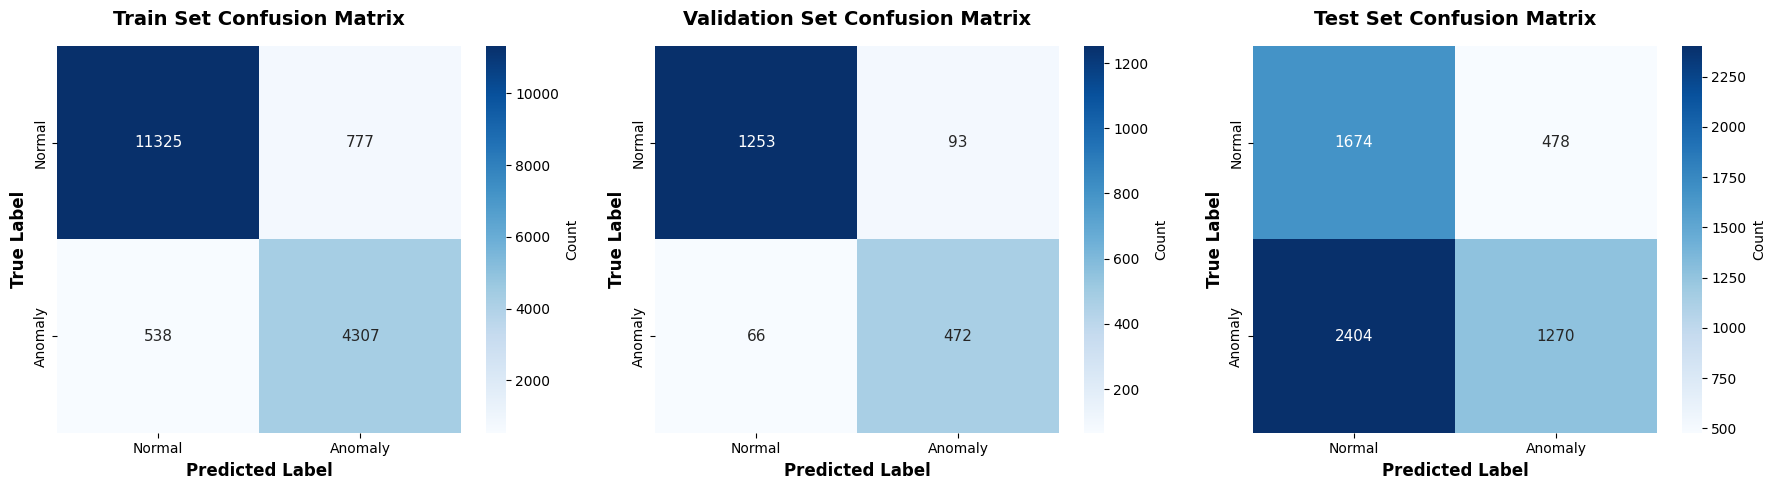

In [56]:
print("\nClassification Report (Autoencoder vs Ground Truth):")
print(print_combined_classification_reports(
    y_train, predicted_anomalies_train,
    y_val, predicted_anomalies_val,
    y_test, predicted_anomalies_test
))
# Confusion matrix
cm = plot_confusion_matrices_combined(
    [y_train_tensor, y_val_tensor, y_test_tensor],
    [predicted_anomalies_train, predicted_anomalies_val, predicted_anomalies_test],
    class_names=['Normal', 'Anomaly'],
    titles=['Train Set Confusion Matrix', 'Validation Set Confusion Matrix', 'Test Set Confusion Matrix']
)

#### Estimate the reconstruction error threshold on the validation set

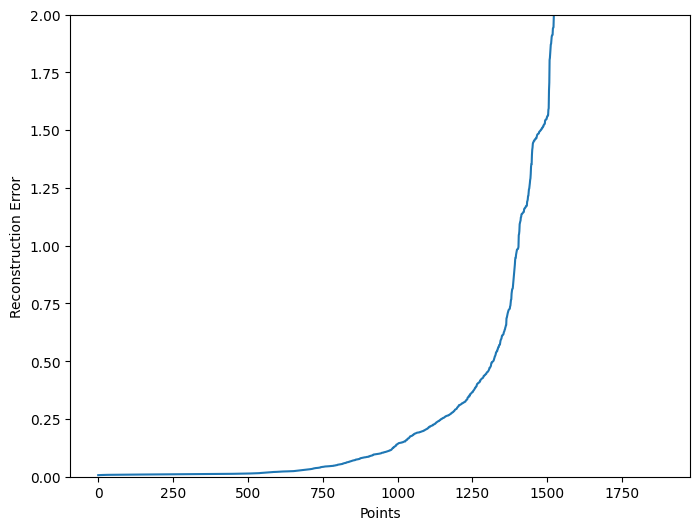

In [57]:
plt.figure(figsize=(8, 6))
plt.plot(sorted(reconstruction_error_val))
plt.xlabel('Points')
plt.ylabel('Reconstruction Error')
plt.ylim(0,2)
plt.show()
plt.close()